# Supervised ML

## Import of the libraries

In [1]:
import dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve,auc, RocCurveDisplay

## Creation of the dataframe

In [ ]:
dataset_path = 'dataset.parquet'

We've created a wapper around the class VorAusDataset in which we've followed the code provided by the paper available at https://github.com/vorausrobotik/voraus-ad-dataset

In [3]:
ds = dataset.VorAusDataset(dataset_path)

We've decided to split the dataset in the usual train_test because our data (fortunately) was labelled.

In [4]:
X_train, y_train, X_test, y_test = ds.get_prepared_dataset_tts(test_size = 0.15, random_state=42)

## Model evaluation

This class is used to encapsulate a sklearn model and it's useful because it comprehends some nice features:
* It's general for each sklearn model so there's no need to have duplicated code;
* Provides all the metrics we need from the predictions;
* Shows 4 types of plot: ROC curve, AUC curve, Confusion Matrix and then the plot of the residuals

In [5]:
class Model:
    def __init__(self, model,name=None, scaled=False):
        self.model = model
        self.name = name
    def fit(self):
        self.model.fit(X_train, y_train)
    def __get_predictions(self):
        return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]

    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series

    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

* $Recall = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$
    * In words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?" It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.


* $Precision = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}$ 
    * In words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?" It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
* $Accuracy = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$
* $F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} \times \text{Recall}}$
    * In words, the F1 score provides a balance between precision and recall. It ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 indicates poor performance

This dataframe is used to save all the performances of the models and it will be used to compare them

In [6]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
            'Precision',
            'Recall',
            'F1-Score',
            'ROC AUC',
            'Confusion Matrix',
            'PR AUC'])

## Logistic Regression

Logistic regression is a statistical method used for binary classification, which means predicting the probability that an instance belongs to one of two classes. Despite its name, logistic regression is primarily employed for classification tasks rather than regression.

In logistic regression, the logistic function, also known as the sigmoid function, is used to model the relationship between the independent variables and the probability of the dependent variable belonging to a particular class. The output of the logistic regression model is a probability score between 0 and 1, and a threshold is typically applied to classify instances into one of the two classes.

The logistic regression model assumes a linear relationship between the independent variables and the log-odds of the probability of the dependent variable. The model is trained by adjusting the weights of the independent variables through an optimization process, often using techniques like maximum likelihood estimation.

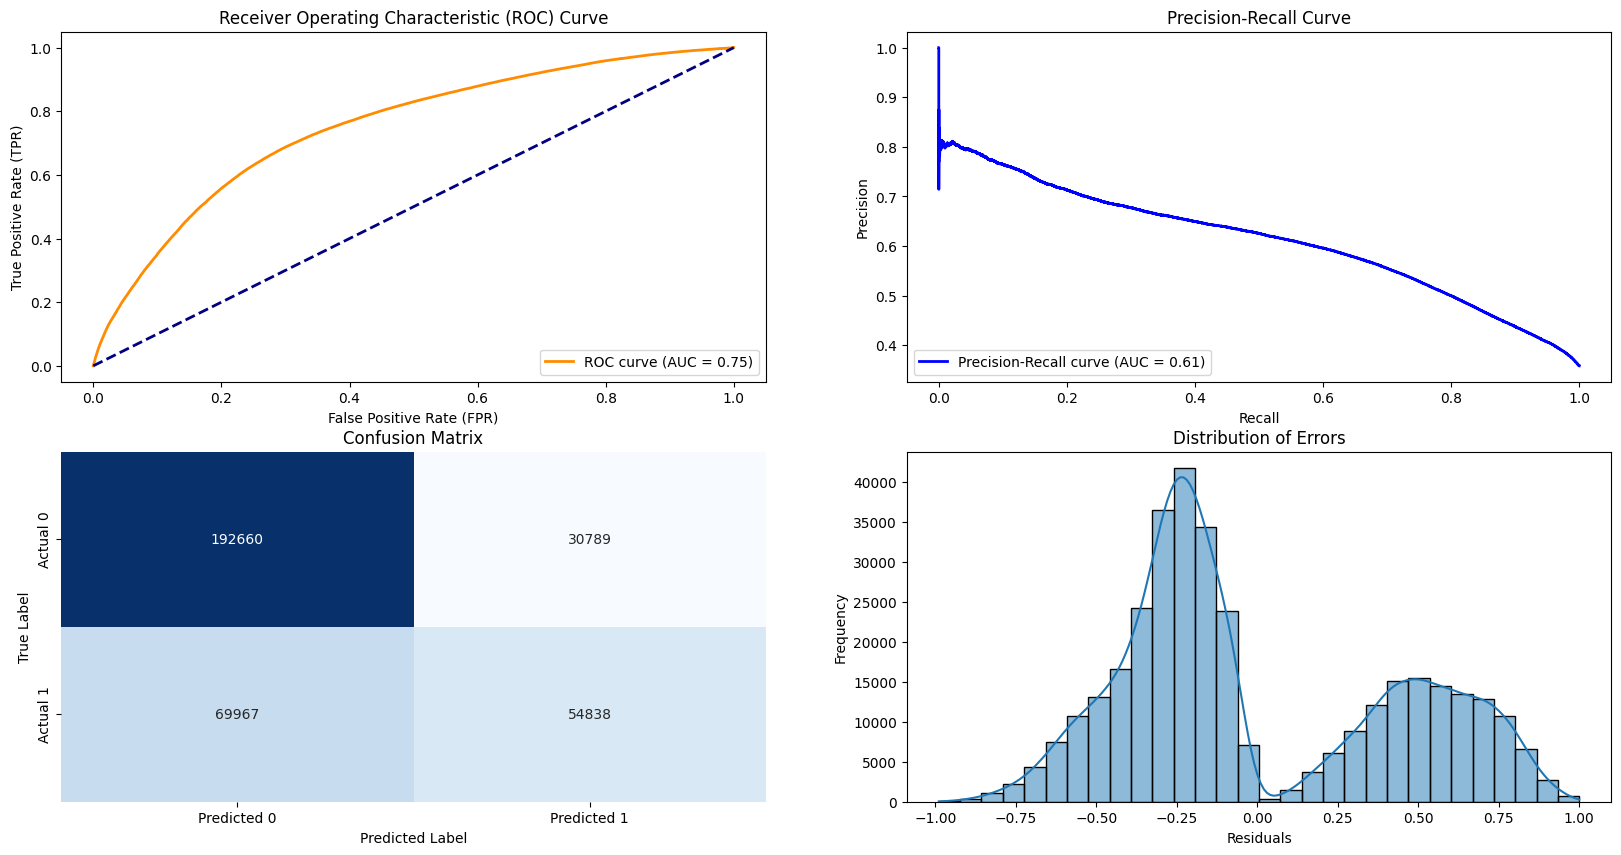

In [7]:
model = Model(LogisticRegression(solver='newton-cholesky'),'Logistic Regression')
model.fit()
model.visualize_metrics()

In [8]:
metrics_lr = model.get_metrics()
models_df = pd.concat([models_df, metrics_lr.to_frame().T])
print(metrics_lr)

Accuracy                                     0.710682
Precision                                    0.640429
Recall                                       0.439389
F1-Score                                     0.521194
ROC AUC                                       0.74864
Confusion Matrix    [[192660, 30789], [69967, 54838]]
PR AUC                                       0.610888
Name                              Logistic Regression
dtype: object


In [9]:
del metrics_lr
del model

# Gaussian Naive Bayes

Naive Bayes is a family of probabilistic algorithms based on Bayes' theorem, which is a fundamental theorem in probability theory. It's based on:
* Bayes' Theorem which calculates the probability of a hypothesis given the observed evidence.
* Independence Assumption: features must be independent from each other

There are a lot of different Naive Bayes algorithms which are based on the distribution of the data. Recalling the fact that 4 of the features follows a normal distribution and from previous calculation we've determined that there is not a lot of dependency between the features so I've decided to use the Gaussian NB algorithm

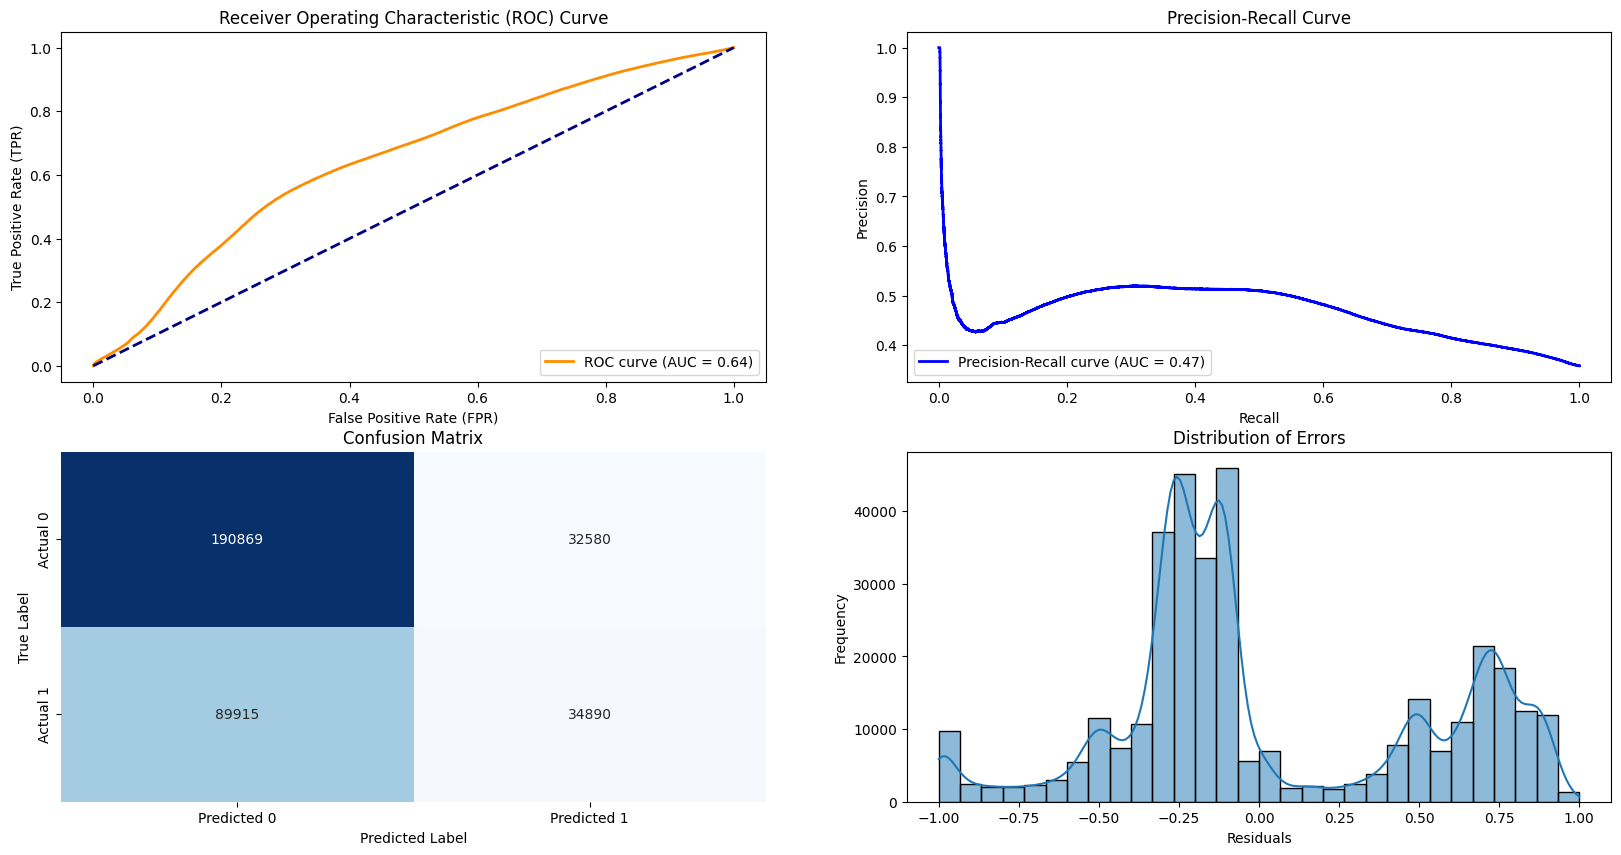

In [10]:
model = Model(GaussianNB(), 'Gaussian Naive Bayes')
model.fit()
model.visualize_metrics()

In [11]:
metrics_LB = model.get_metrics()
models_df = pd.concat([models_df, metrics_LB.to_frame().T])
print(metrics_LB)

Accuracy                                      0.64826
Precision                                    0.517119
Recall                                       0.279556
F1-Score                                     0.362918
ROC AUC                                      0.643212
Confusion Matrix    [[190869, 32580], [89915, 34890]]
PR AUC                                       0.466222
Name                             Gaussian Naive Bayes
dtype: object


In [12]:
del model
del metrics_LB

## Decision Tree

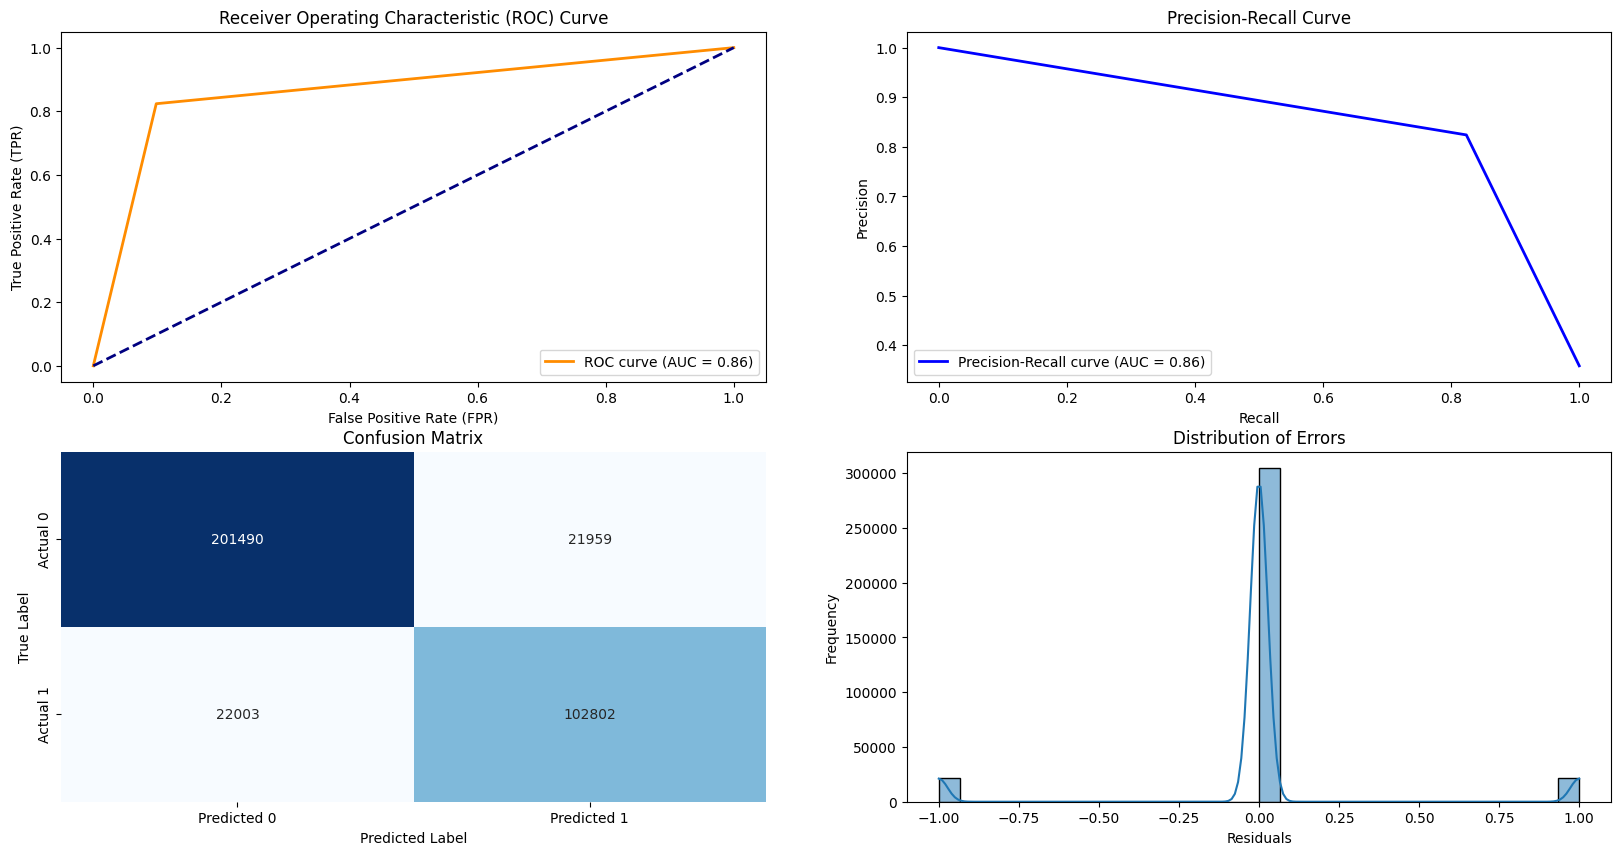

In [13]:
model = Model(DecisionTreeClassifier(), 'Decision Tree Classifier')
model.fit()
model.visualize_metrics()

In [14]:
metrics_DT = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT.to_frame().T])
print(metrics_DT)

Accuracy                                      0.873765
Precision                                     0.823991
Recall                                        0.823701
F1-Score                                      0.823846
ROC AUC                                       0.862714
Confusion Matrix    [[201490, 21959], [22003, 102802]]
PR AUC                                        0.741903
Name                          Decision Tree Classifier
dtype: object


In [15]:
del model
del metrics_DT

## Random Forest

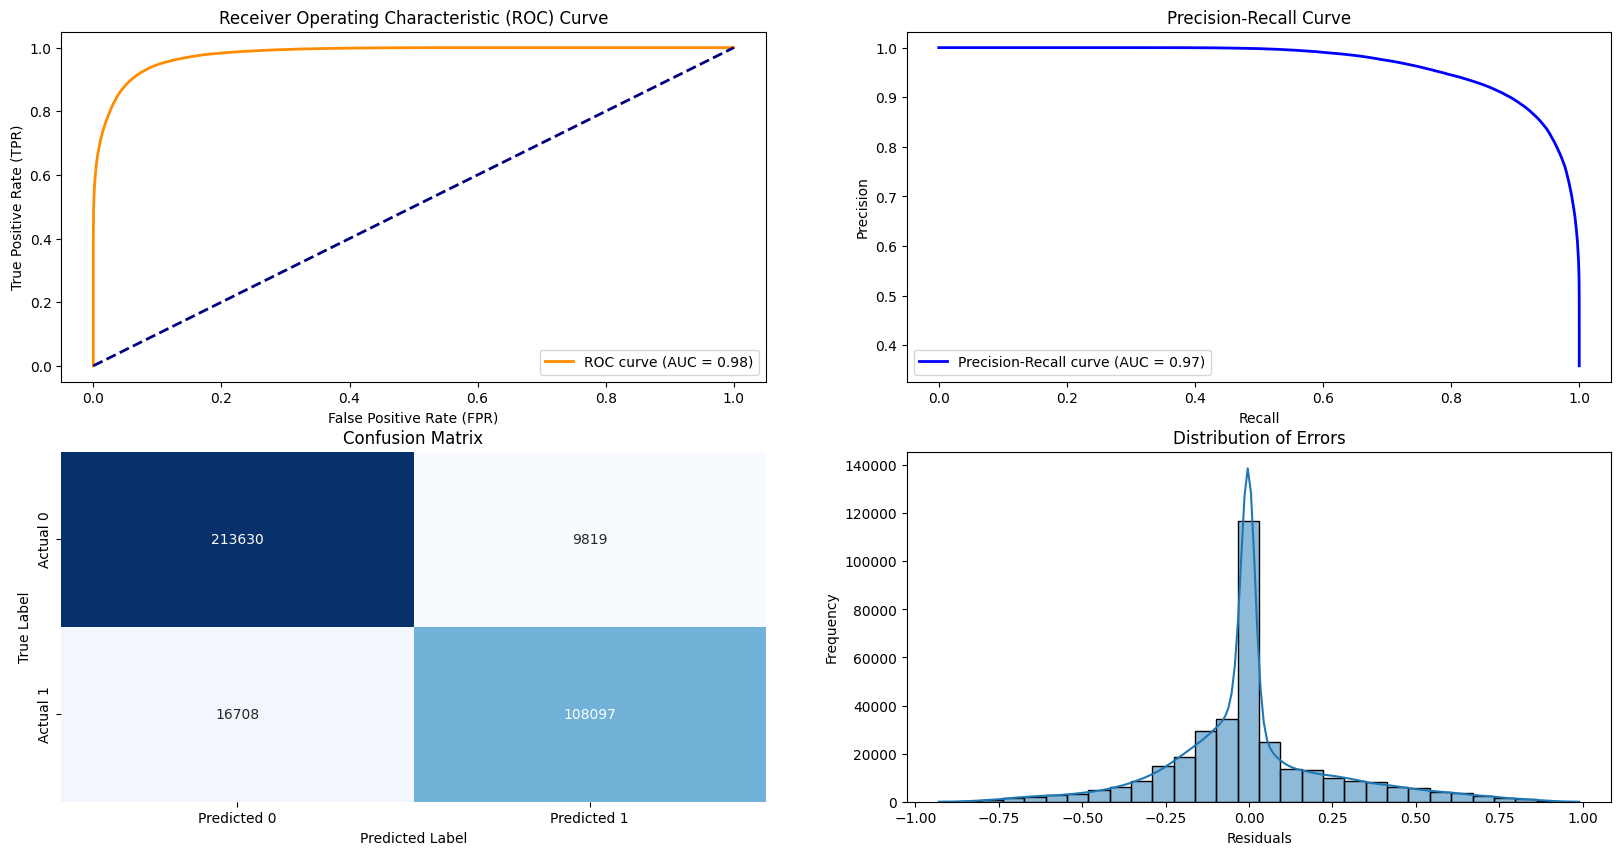

In [17]:
model = Model(RandomForestClassifier())
model.fit()
model.visualize_metrics()  

In [19]:
metrics_RandomForest = model.get_metrics()
models_df = pd.concat([models_df, metrics_RandomForest.to_frame().T])
print(metrics_RandomForest)

Accuracy                                     0.923829
Precision                                    0.916729
Recall                                       0.866127
F1-Score                                      0.89071
ROC AUC                                      0.979921
Confusion Matrix    [[213630, 9819], [16708, 108097]]
PR AUC                                       0.966065
Name                           RandomForestClassifier
dtype: object


### Feature importance of the Random Forest Tree

The impurity-based feature importances.

The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [20]:
sorted_idx = model.model.feature_importances_.argsort()[::-1]
cols  = []
columns = ds.get_columns()
for i in sorted_idx:
    cols.append(columns[i])

<BarContainer object of 10 artists>

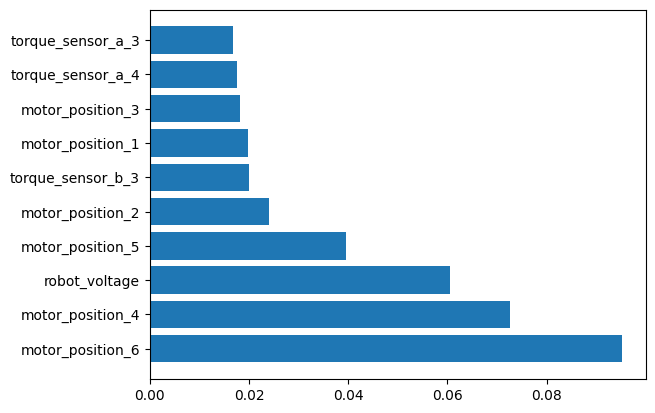

In [21]:
plt.barh(cols[:10 ], model.model.feature_importances_[sorted_idx][:10 ])

In [22]:
del model

# Gradient Boosting

Gradient Boosting is an ensemble learning technique that combines the predictions of multiple weak learners (typically decision trees) to create a strong predictive model. The Gradient Boosting Classifier, specifically, is used for classification tasks.

Here's a brief description of the Gradient Boosting Classifier:

* <b>Base Learners (Weak Models)</b>: The algorithm starts with an initial weak learner, often a shallow decision tree. The model initially makes predictions, and the errors or residuals (the differences between predicted and actual values) are identified.
* <b>Gradient Descent Optimization</b>: In subsequent iterations, new weak learners are added to the ensemble, and they focus on correcting the errors made by the existing ensemble. The optimization process is akin to descending a gradient in the error space, hence the name "gradient boosting."
* <b>Weighted Contributions</b>: Each weak learner contributes to the final prediction with a certain weight. The weights are determined during the training process, and they depend on the contribution of each learner in minimizing the overall prediction error.
* <b>Shrinkage (Learning Rate)</b>: A hyperparameter called the learning rate controls the contribution of each weak learner. A smaller learning rate requires more weak learners but often leads to better generalization.
* <b>Regularizatio</b>>: Gradient Boosting includes regularization techniques to prevent overfitting. This may involve constraining the complexity of the individual weak learners or introducing penalties for large weights.
* <b>Prediction</b>: The final prediction is made by aggregating the predictions of all weak learners, and the class with the majority of votes is selected as the predicted class for classification tasks.

### SKLEARN implementation

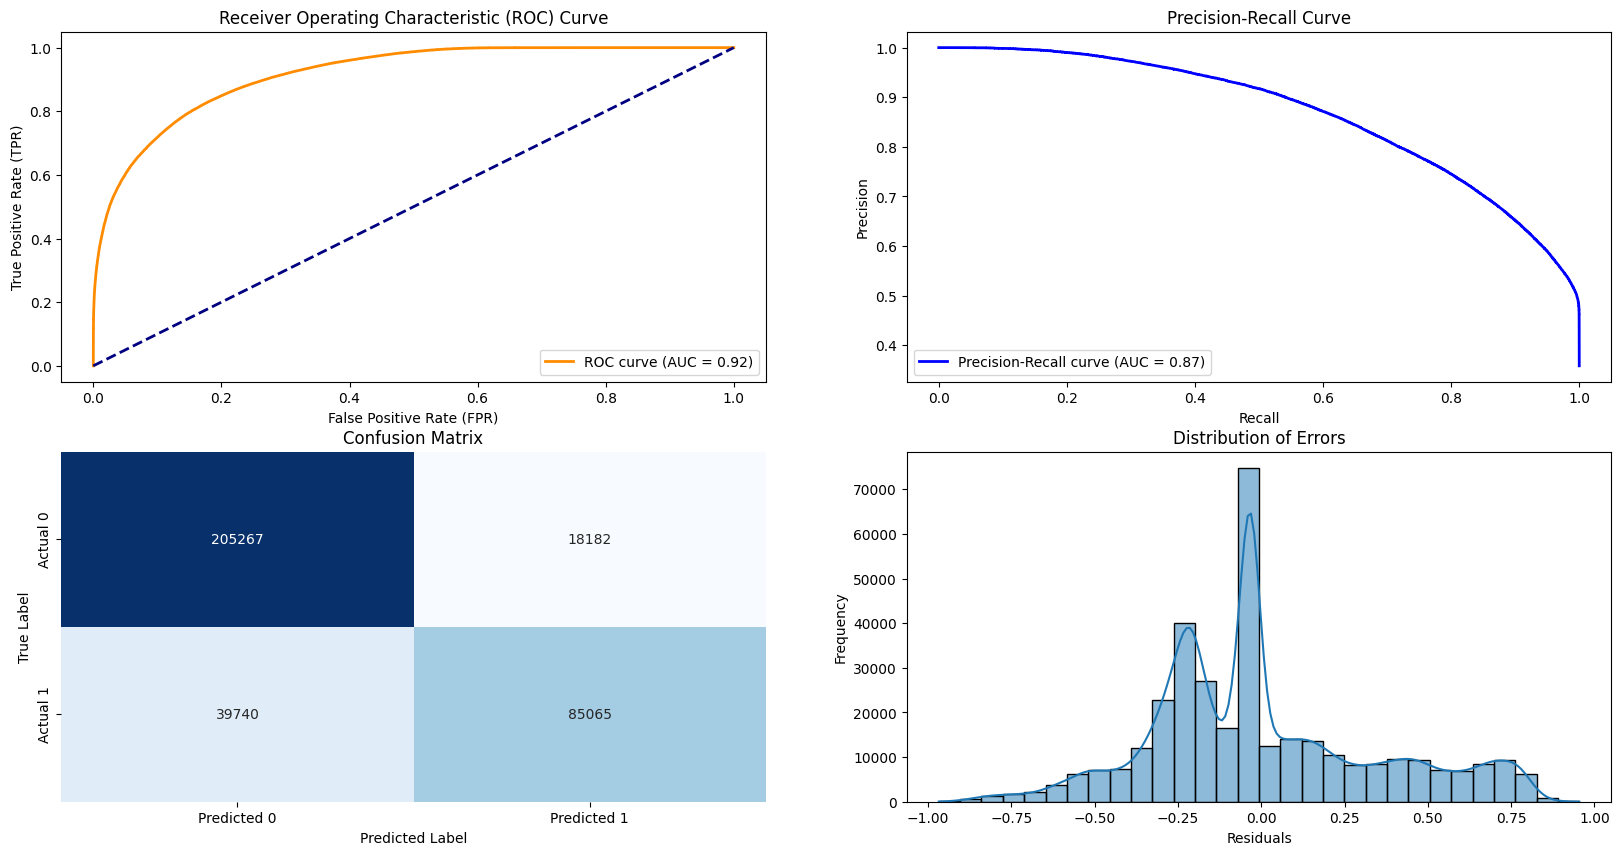

In [23]:
model = Model(GradientBoostingClassifier(n_estimators=50, learning_rate=0.2,max_depth=5,min_samples_leaf=50,
                                 min_samples_split=40,max_features='sqrt', random_state=42), name='Gradient Boosting Classifier')
model.fit()
model.visualize_metrics()

In [24]:
metrics_GBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC.to_frame().T])
print(metrics_GBC)

Accuracy                                     0.833679
Precision                                    0.823898
Recall                                       0.681583
F1-Score                                     0.746014
ROC AUC                                      0.915578
Confusion Matrix    [[205267, 18182], [39740, 85065]]
PR AUC                                       0.867363
Name                     Gradient Boosting Classifier
dtype: object


### Feature importance of Gradient Boosting

N.B: by default the features uses the Gini Index

In [25]:
sorted_idx = model.model.feature_importances_.argsort()[::-1]
cols  = []
columns = ds.get_columns()
for i in sorted_idx:
    cols.append(columns[i])

Text(0.5, 1.0, 'Feature importance Gradient boosting')

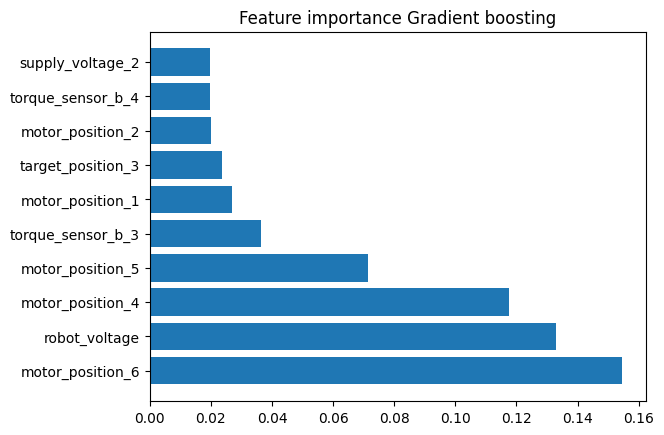

In [26]:
plt.barh(cols[:10 ], model.model.feature_importances_[sorted_idx][:10 ])
plt.title('Feature importance Gradient boosting')

In [27]:
del model
del metrics_GBC

### Xg Boost

Extreme Gradient Boosting (XGBoost) is a highly efficient and scalable implementation of gradient boosting, a machine learning technique for regression and classification tasks. XGBoost stands out due to its performance and flexibility, making it a popular choice in competitive data science and machine learning applications. The strong points of this model are:

* Scalability and Speed: XGBoost is designed for high performance on large datasets. It can handle missing values and supports parallel and distributed computing, making it suitable for big data applications. Its ability to handle sparse data efficiently is also a significant advantage.

* Regularization: To prevent overfitting, XGBoost incorporates regularization techniques, including L1 (Lasso) and L2 (Ridge) regularization. This helps improve the model's generalization capabilities.

* Handling Missing Values: XGBoost can manage datasets with missing values by learning the best imputation values during the training process.

* Tree Pruning: Instead of the traditional depth-first approach, XGBoost uses a more sophisticated method called "max depth" to prune trees. This method ensures the algorithm grows trees in a balanced manner, improving both performance and model interpretability.

* Weighted Quantile Sketch: XGBoost includes a novel weighted quantile sketch algorithm, which allows it to handle weighted data more effectively. This is particularly useful in scenarios where data points have varying importance.

* Sparsity Aware: The algorithm is designed to make efficient use of sparse data structures, which are common in real-world datasets. This capability reduces memory usage and computation time.

* Cross-Validation and Early Stopping: XGBoost supports integrated cross-validation and early stopping, which can halt the training process if the model's performance on a validation set does not improve, thus saving time and resources.

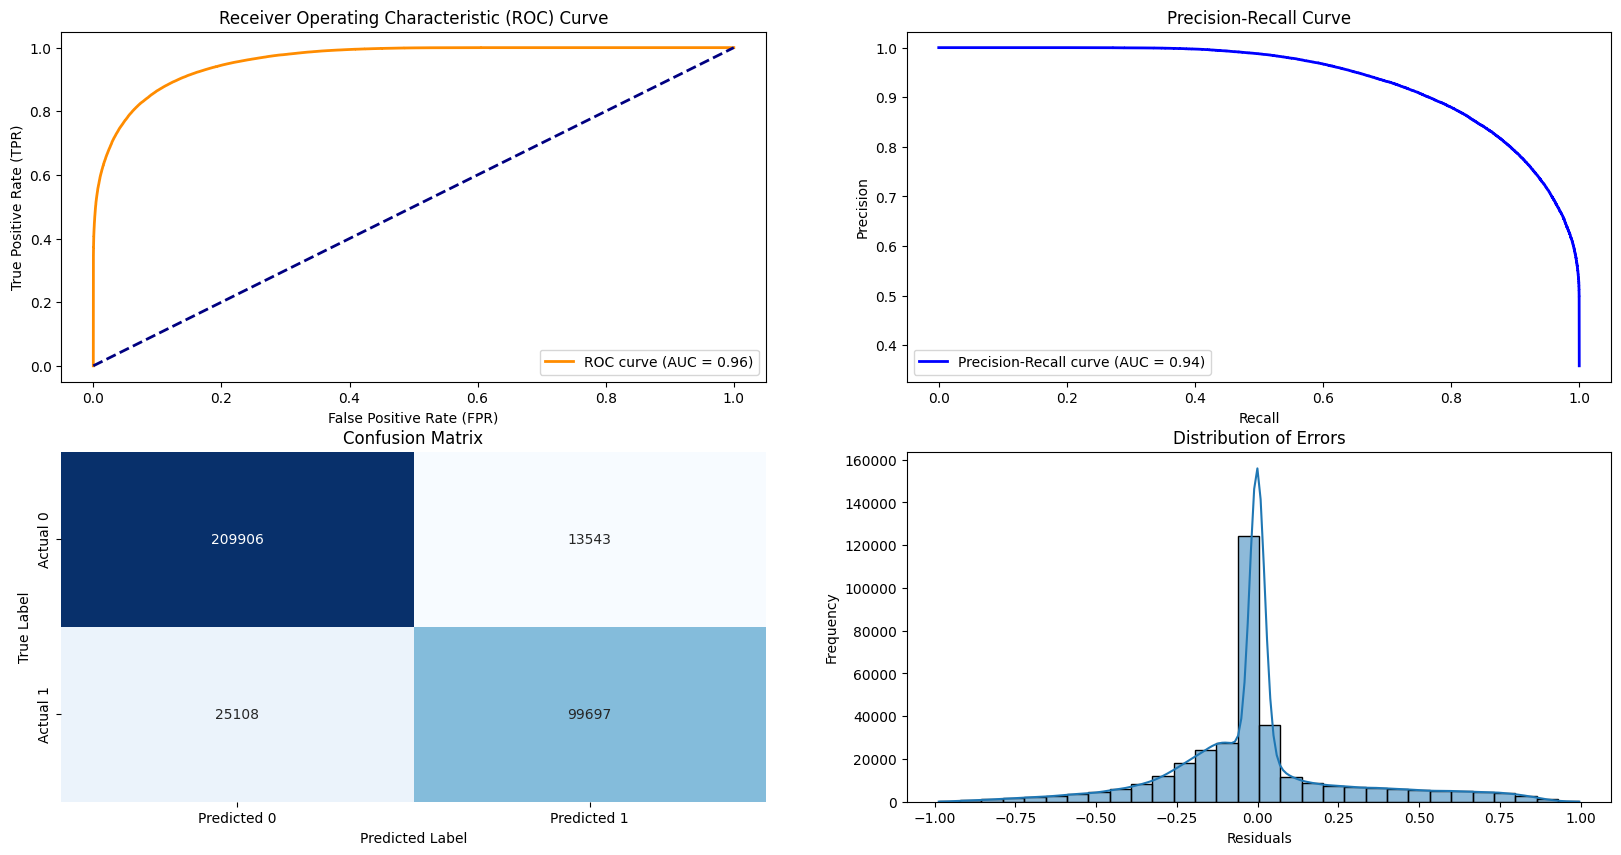

In [28]:
model = Model(XGBClassifier(), 'XGB classifier')
model.fit()
model.visualize_metrics()

In [29]:
metrics_XGBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_XGBC.to_frame().T])
print(metrics_XGBC)

Accuracy                                     0.889015
Precision                                    0.880404
Recall                                       0.798822
F1-Score                                     0.837632
ROC AUC                                      0.960141
Confusion Matrix    [[209906, 13543], [25108, 99697]]
PR AUC                                       0.936866
Name                                   XGB classifier
dtype: object


### Feature importance of the XGBoost

In [30]:
sorted_idx = model.model.feature_importances_.argsort()[::-1]

In [31]:
cols  = []
columns = ds.get_columns()
for i in sorted_idx:
    cols.append(columns[i])

Text(0.5, 1.0, 'Feature Importance XGBoost')

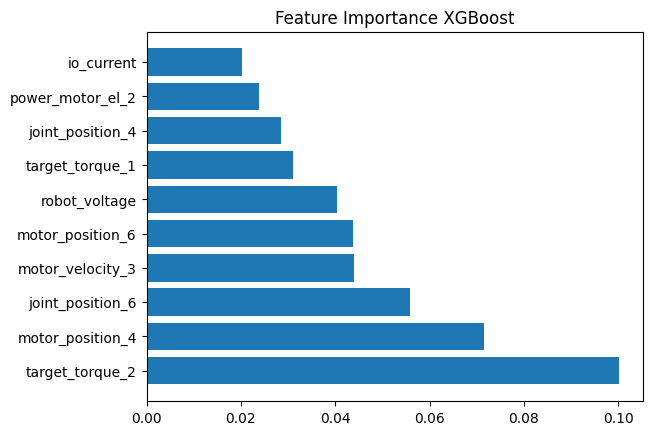

In [32]:
plt.barh(cols[:10 ], model.model.feature_importances_[sorted_idx][:10 ])
plt.title('Feature Importance XGBoost')

# Comparison

In [33]:
models_df

,Name,Accuracy,Precision,Recall,F1-Score,ROC AUC,Confusion Matrix,PR AUC
0,Logistic Regression,0.710682,0.640429,0.439389,0.521194,0.74864,"[[192660, 30789], [69967, 54838]]",0.610888
0,Gaussian Naive Bayes,0.64826,0.517119,0.279556,0.362918,0.643212,"[[190869, 32580], [89915, 34890]]",0.466222
0,Decision Tree Classifier,0.873765,0.823991,0.823701,0.823846,0.862714,"[[201490, 21959], [22003, 102802]]",0.741903
0,RandomForestClassifier,0.923829,0.916729,0.866127,0.89071,0.979921,"[[213630, 9819], [16708, 108097]]",0.966065
0,Gradient Boosting Classifier,0.833679,0.823898,0.681583,0.746014,0.915578,"[[205267, 18182], [39740, 85065]]",0.867363
0,XGB classifier,0.889015,0.880404,0.798822,0.837632,0.960141,"[[209906, 13543], [25108, 99697]]",0.936866


In [34]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

<Axes: xlabel='Name'>

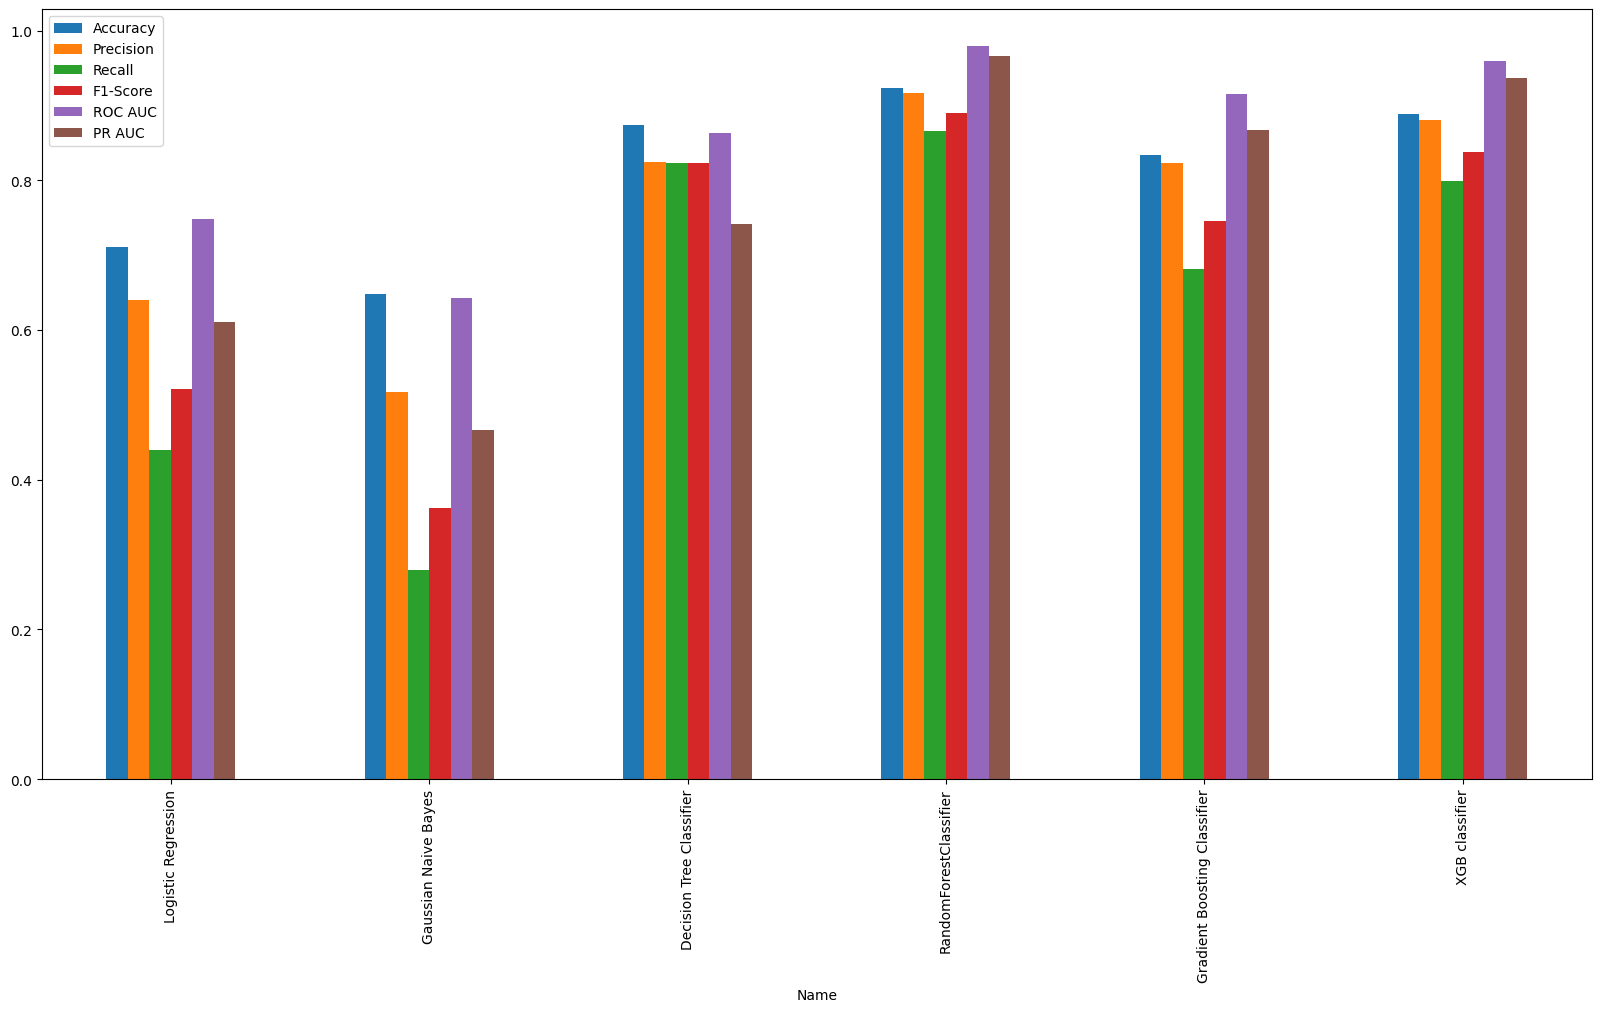

In [35]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

In [ ]:
for col in models_df.columns:
    if col != 'Confusion Matrix':
        print(models_df.sort_values(by=col, ascending=False)[col].head(1))

Name
RandomForestClassifier    0.922597
Name: Accuracy, dtype: object
Name
RandomForestClassifier    0.91523
Name: Precision, dtype: object
Name
RandomForestClassifier    0.864044
Name: Recall, dtype: object
Name
RandomForestClassifier    0.888901
Name: F1-Score, dtype: object
Name
RandomForestClassifier    0.979425
Name: ROC AUC, dtype: object
Name
RandomForestClassifier    0.965173
Name: PR AUC, dtype: object
